## Setup

In [1]:
import random
from collections import Counter
import itertools
import math

import networkx as nx
import numpy as np
import pandas as pd
from scipy.special import softmax
from tqdm import trange, tqdm

In [189]:
class Car:
    def __init__(self, source, target) -> None:
        self.source = source
        self.target = target

    def __repr__(self) -> str:
        return f'<Car {self.source} -> {self.target}>'

    def act(self, network, verbose=False):
        if self.source == self.target or not nx.has_path(network, self.source, self.target):
            return self.source
        else:
            choices = list(nx.all_shortest_paths(network, self.source, self.target, weight='anticipated_latency'))
            choice = random.choice(choices)
            
            if verbose:
                print(f'Choose {choice} from {choices}.')
            
            return choice
            

class TrafficModel:
    def __init__(self, network, cars) -> None:
        self.network = network
        self.cars = cars

    def update_latencies(self):
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in self.network.edges(data=True)}, 'latency')
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['utilization'] + (1 / len(self.cars))) for v, w, attr in self.network.edges(data=True)}, 'anticipated_latency')

    def update_latency(self, edge):
        self.network.edges[edge]['latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['utilization'])
        self.network.edges[edge]['anticipated_latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['utilization'] + (1 / len(self.cars)))

    @property
    def allowed_network(self):
        return nx.restricted_view(self.network, [], [(v, w) for v, w, allowed in self.network.edges(data='allowed') if not allowed])
    
    def decrease_utilization(self, edge):
        self.set_utilization(edge, self.network.edges[edge]['utilization'] - (1 / len(self.cars)))

    def increase_utilization(self, edge):
        self.set_utilization(edge, self.network.edges[edge]['utilization'] + (1 / len(self.cars)))

    def set_utilization(self, edge, utilization):
        self.network.edges[edge]['utilization'] = utilization
        self.update_latency(edge)

    def open_edge(self, edge):
        self.allow_edge(edge, True)

    def close_edge(self, edge):
        self.allow_edge(edge, False)

    def allow_edge(self, edge, allowed=True):
        self.network.edges[edge]['allowed'] = allowed

In [194]:
def run(model, number_of_steps, verbose=False):
    routes = {id: [] for id in model.cars}

    nx.set_edge_attributes(model.network, 0, 'utilization')
    model.update_latencies()

    stats = []
    stats2 = []
    for step in (range if verbose else trange)(number_of_steps):
        if verbose:
            print(f'Step {step}:')
            print(f'Initial latency = {nx.get_edge_attributes(model.network, "latency")}')

        for id, car in np.random.permutation(list(model.cars.items())):
            for edge in zip(routes[id], routes[id][1:]):
                model.decrease_utilization(edge)

            # Let agents choose a route, given the network with allowed edges only
            routes[id] = car.act(model.allowed_network, verbose=verbose)

            for edge in zip(routes[id], routes[id][1:]):
                model.increase_utilization(edge)

        stats.append({
            **routes, 
            **nx.get_edge_attributes(model.network, 'latency'), 
            **{f't({id})': nx.path_weight(model.network, route, 'latency') for id, route in routes.items()}})

        for id, car in np.random.permutation(list(model.cars.items())):
            stats2.append({'step': step, 'car_id': id, 'source': car.source, 'target': car.target, 'route': tuple(routes[id]), 'travel_time': nx.path_weight(model.network, routes[id], 'latency')})

    return pd.DataFrame(stats), pd.DataFrame(stats2)

## Braess Paradox

In [195]:
def create_braess_network():
    network = nx.DiGraph([(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)])

    nx.set_node_attributes(network, {i: (i / 3, 0) for i in range(len(network.nodes))}, 'position')

    # Latency is defined in terms of the utilization, i.e., the share of cars on a specific road
    latency_fns = {
        (0, 0): lambda u: 1,
        (0, 1): lambda u: 8 * u,
        (0, 2): lambda u: 11,
        (1, 1): lambda u: 1,
        (1, 2): lambda u: 1,
        (1, 3): lambda u: 11,
        (2, 2): lambda u: 1,
        (2, 3): lambda u: 8 * u,
        (3, 3): lambda u: 1
    }

    nx.set_edge_attributes(network, latency_fns, 'latency_fn')

    nx.set_edge_attributes(network, 0, 'utilization')
    nx.set_edge_attributes(network, True, 'allowed')

    return network

### Basic version

In [196]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network()
cars = {id: Car(0, 3) for id in range(number_of_cars)}

model = TrafficModel(network, cars)

model.close_edge((1, 2))
stats, stats2 = run(model, number_of_steps, verbose=True)

# Calculate social welfare as mean agent reward per step
stats['social_welfare'] = stats[[f't({id})' for id in range(number_of_cars)]].mean(axis=1)

Step 0:
Initial latency = {(0, 0): 1, (0, 1): 0, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 0, (3, 3): 1}
Choose [0, 2, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 1, 3] from [[0, 1, 3]].
Choose [0, 1, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 2, 3] from [[0, 2, 3]].
Choose [0, 2, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 1, 3] from [[0, 1, 3]].
Choose [0, 2, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 1, 3] from [[0, 1, 3]].
Choose [0, 1, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 2, 3] from [[0, 2, 3]].
Choose [0, 2, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 1, 3] from [[0, 1, 3]].
Choose [0, 2, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 1, 3] from [[0, 1, 3]].
Choose [0, 2, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 1, 3] from [[0, 1, 3]].
Choose [0, 2, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 1, 3] from [[0, 1, 3]].
Choose [0, 1, 3] from [[0, 1, 3], [0, 2, 3]].
Choose [0, 2, 3] from [[0, 2, 3]].
Step 1:
Initial latency = {(0, 0): 1, (0, 1): 3.99999999999999

<Axes: >

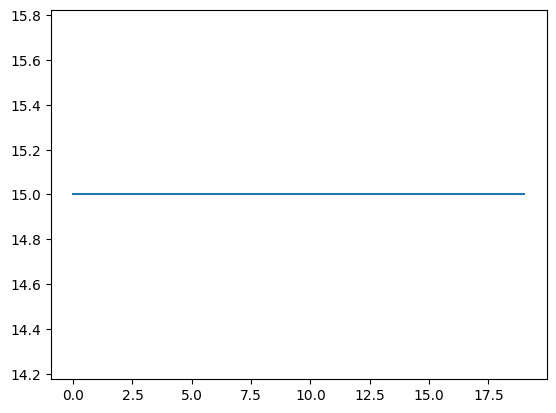

In [197]:
stats['social_welfare'].plot()

<Axes: xlabel='step'>

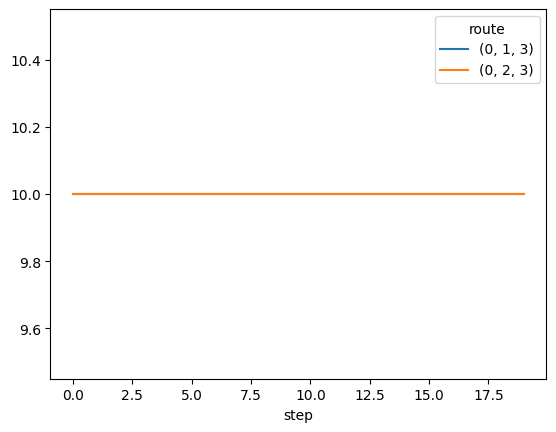

In [198]:
stats2.groupby(['step', 'route']).size().unstack().plot()

### With random initialization of cars

In [203]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network()
cars = {id: Car(s, t) for id, (s, t) in zip(range(number_of_cars), random.choices([(0, 2), (0, 3), (1, 3)], k=number_of_cars))}
print(f'Cars: {cars}')

model = TrafficModel(network, cars)

model.allow_edge((1, 2))
stats, stats2 = run(model, number_of_steps, verbose=True)

# Calculate social welfare as mean agent reward per step
stats['social_welfare'] = stats[[f't({id})' for id in range(number_of_cars)]].mean(axis=1)

Cars: {0: <Car 0 -> 2>, 1: <Car 0 -> 2>, 2: <Car 1 -> 3>, 3: <Car 1 -> 3>, 4: <Car 0 -> 2>, 5: <Car 0 -> 3>, 6: <Car 1 -> 3>, 7: <Car 0 -> 2>, 8: <Car 0 -> 3>, 9: <Car 0 -> 2>, 10: <Car 0 -> 3>, 11: <Car 0 -> 3>, 12: <Car 0 -> 3>, 13: <Car 0 -> 3>, 14: <Car 0 -> 2>, 15: <Car 0 -> 3>, 16: <Car 1 -> 3>, 17: <Car 1 -> 3>, 18: <Car 1 -> 3>, 19: <Car 0 -> 2>}
Step 0:
Initial latency = {(0, 0): 1, (0, 1): 0, (0, 2): 11, (1, 1): 1, (1, 2): 1, (1, 3): 11, (2, 2): 1, (2, 3): 0, (3, 3): 1}
Choose [1, 2, 3] from [[1, 2, 3]].
Choose [1, 2, 3] from [[1, 2, 3]].
Choose [0, 1, 2, 3] from [[0, 1, 2, 3]].
Choose [1, 2, 3] from [[1, 2, 3]].
Choose [0, 1, 2] from [[0, 1, 2]].
Choose [0, 1, 2, 3] from [[0, 1, 2, 3]].
Choose [0, 1, 2, 3] from [[0, 1, 2, 3]].
Choose [0, 1, 2] from [[0, 1, 2]].
Choose [0, 1, 2] from [[0, 1, 2]].
Choose [1, 2, 3] from [[1, 2, 3]].
Choose [0, 1, 2] from [[0, 1, 2]].
Choose [1, 2, 3] from [[1, 2, 3]].
Choose [0, 1, 2, 3] from [[0, 1, 2, 3]].
Choose [0, 1, 2] from [[0, 1, 2]].
C

<Axes: >

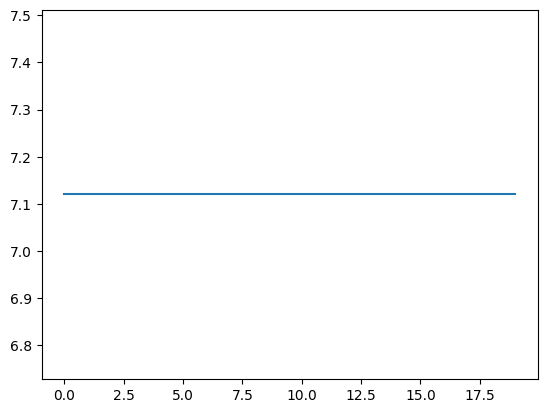

In [200]:
# Social welfare (i.e., mean travel time) over all time steps

stats['social_welfare'].plot()

route
(0, 1, 2)       Axes(0.125,0.11;0.775x0.77)
(0, 1, 2, 3)    Axes(0.125,0.11;0.775x0.77)
(1, 2, 3)       Axes(0.125,0.11;0.775x0.77)
Name: travel_time, dtype: object

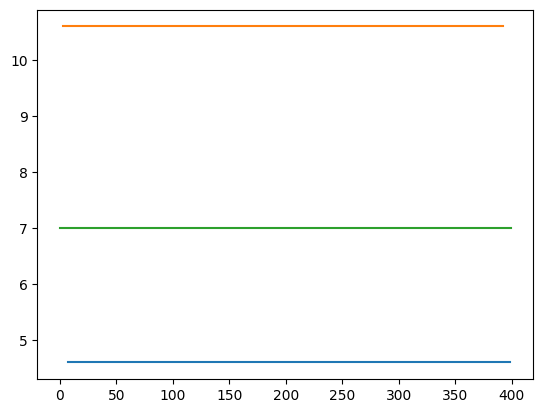

In [201]:
# Travel time per route over all time steps

stats2.groupby('route')['travel_time'].plot()

<Axes: xlabel='step'>

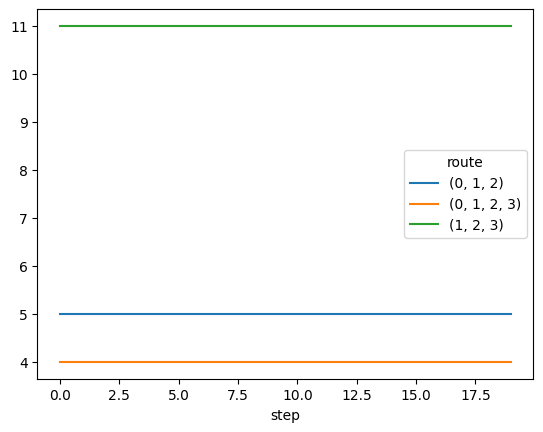

In [202]:
# Number of cars per route over all time steps

stats2.groupby(['step', 'route']).size().unstack().plot()

<Axes: >

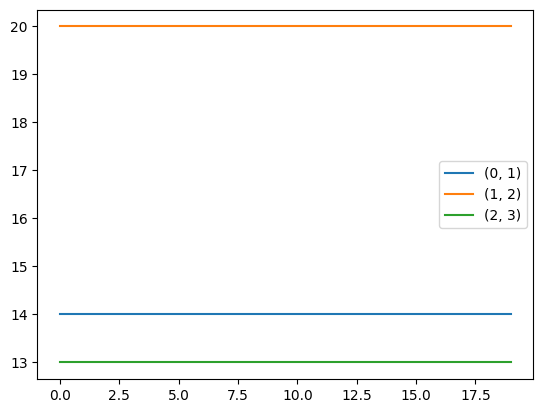

In [229]:
# Number of cars per edge over all time steps

pd.DataFrame(list(stats2.groupby('step')['route'].aggregate(lambda routes: Counter([edge for route in routes for edge in tuple(zip(route, route[1:]))])))).plot()

## Grid with random latency functions

In [230]:
def create_grid_network(number_of_rows, number_of_columns):
    network = nx.grid_2d_graph(number_of_rows, number_of_columns, create_using=nx.DiGraph)

    nx.set_node_attributes(network, {(i, j): (j / (number_of_columns - 1), i / (number_of_rows - 1)) for i, j in network.nodes}, 'position')
    nx.set_edge_attributes(network, lambda u: 1 + u, 'latency_fn')
    nx.set_edge_attributes(network, 0, 'utilization')
    nx.set_edge_attributes(network, True, 'allowed')

    return network

In [235]:
number_of_rows = 4
number_of_columns = 5
number_of_cars = 20
number_of_steps = 100

network = create_grid_network(number_of_rows, number_of_columns)
cars = {id: Car((0, 0), (number_of_rows - 1, number_of_columns - 1)) for id in range(number_of_cars)}

model = TrafficModel(network, cars)
stats, stats2 = run(model, number_of_steps)

# Calculate social welfare as mean agent reward per step
stats['social_welfare'] = stats[[f't({id})' for id in range(number_of_cars)]].mean(axis=1)

100%|██████████| 100/100 [00:00<00:00, 247.65it/s]


<Axes: >

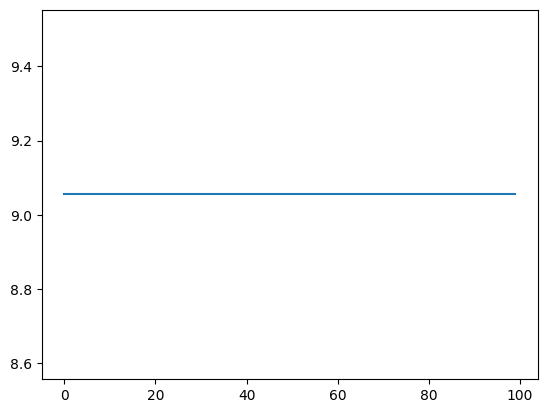

In [236]:
stats['social_welfare'].plot()

<Axes: xlabel='step'>

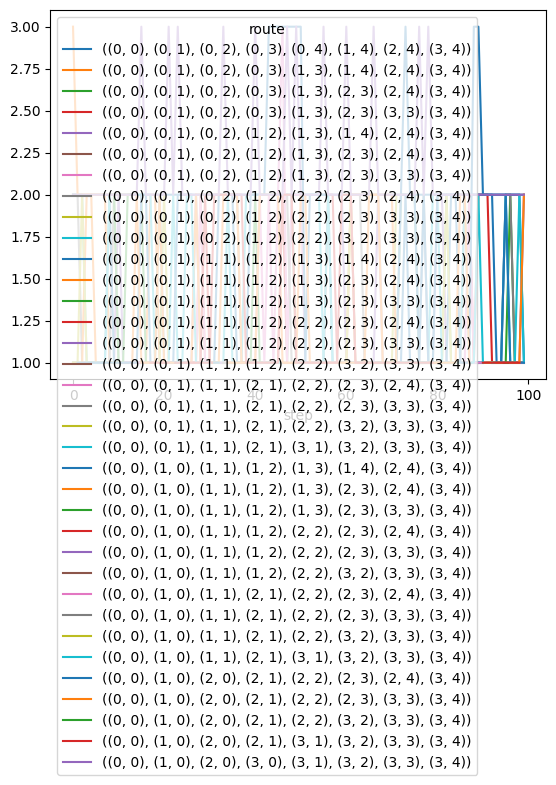

In [237]:
stats2.groupby(['step', 'route']).size().unstack().plot()

<Axes: >

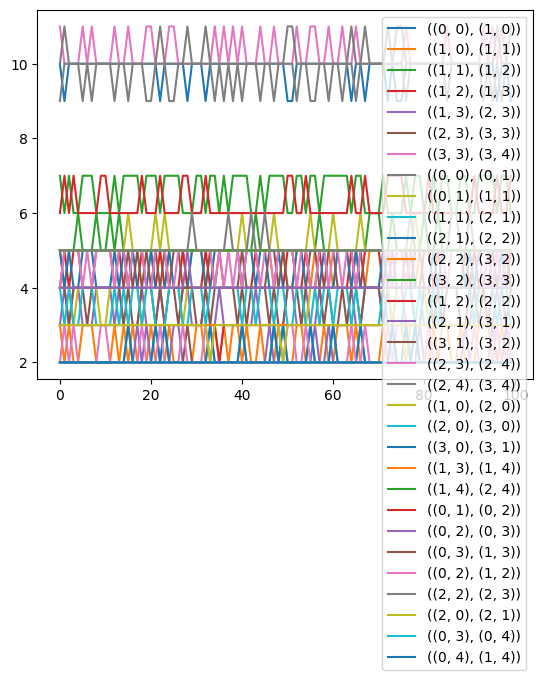

In [238]:
# Number of cars per edge over all time steps

pd.DataFrame(list(stats2.groupby('step')['route'].aggregate(lambda routes: Counter([edge for route in routes for edge in tuple(zip(route, route[1:]))])))).plot()